In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import pandas as pd
import re
import json

In [2]:
judge_model_name = "Qwen/Qwen2.5-7B-Instruct"

tokenizer_judge = AutoTokenizer.from_pretrained(judge_model_name)

model_judge = AutoModelForCausalLM.from_pretrained(
    judge_model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

`torch_dtype` is deprecated! Use `dtype` instead!
2025-12-25 23:53:40.400077: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-25 23:53:40.447624: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-25 23:53:42.546906: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
import pandas as pd

file_path = "/faststorage/project/DEIC-SDU-L2-22/llmproject/movielens/history/v2/results_predictions_ml_history_ml2.json"
df = pd.read_json(file_path)

# Afficher les 5 premières lignes
print(df.head())

                                              prompt  true_label  \
0  ### Instruction:\nPredict the rating (an integ...           4   
1  ### Instruction:\nPredict the rating (an integ...           3   
2  ### Instruction:\nPredict the rating (an integ...           4   
3  ### Instruction:\nPredict the rating (an integ...           4   
4  ### Instruction:\nPredict the rating (an integ...           5   

   predicted_label  
0                4  
1                4  
2                4  
3                4  
4                4  


In [4]:
print(df["prompt"].iloc[0])

### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1442, Genres="Drama"

### Response:


In [6]:
# def create_judge_prompt(user_movie_history, predicted_rating):
#     prompt = (
#         "You are a movie rating coherence evaluator.\n"
#         "Your task is to judge whether the predicted rating is coherent with "
#         "the user's movie history.\n\n"
#         "You MUST respond STRICTLY in valid JSON format like this:\n"
#         "{\n"
#         "  \"coherence_score\": float between 0 and 1,\n"
#         "  \"verdict\": \"coherent\" or \"incoherent\",\n"
#         "  \"explanation\": \"short explanation\"\n"
#         "}\n\n"
#         f"User Movie History:\n{user_movie_history}\n\n"
#         f"Predicted Rating: {predicted_rating}\n\n"
#         "Return ONLY valid JSON. No extra text."
#     )
#     return prompt


In [ ]:
# def ask_qwen_judge(prompt):
#     inputs = tokenizer_judge(prompt, return_tensors="pt").to(model_judge.device)

#     output = model_judge.generate(
#         **inputs,
#         max_new_tokens=200,
#         temperature=0.2
#     )

#     full_text = tokenizer_judge.decode(output[0], skip_special_tokens=True)

#     # Remove prompt from output
#     generated = full_text.replace(prompt, "").strip()
#     generated = generated.replace("```json", "").replace("```", "").strip()

#     try:
#         result = json.loads(generated)
#     except:
#         result = {
#             "coherence_score": 0.0,
#             "verdict": "unknown",
#             "explanation": "Model returned invalid JSON."
#         }

#     return result


# # =====================================================
# # 3. Load MovieLens prediction file
# # =====================================================
# file_path = "/faststorage/project/DEIC-SDU-L2-22/llmproject/movielens/history/v2/results_predictions_ml_history_ml2.json"
# df = pd.read_json(file_path)


# # =====================================================
# # 4. Extract history & evaluate coherence
# # =====================================================
# records = []

# for idx, prompt_text in enumerate(df["prompt"]):

#     # Extract User Movie History
#     history_match = re.search(
#         r'User Movie History:\s*(.*?)\s*Target Movie:',
#         prompt_text,
#         re.DOTALL
#     )
#     user_movie_history = history_match.group(1).strip() if history_match else ""

#     predicted_rating = df["predicted_label"].iloc[idx]

#     judge_prompt = create_judge_prompt(
#         user_movie_history=user_movie_history,
#         predicted_rating=predicted_rating
#     )

#     judge_output = ask_qwen_judge(judge_prompt)

#     records.append({
#         "user_movie_history": user_movie_history,
#         "predicted_rating": predicted_rating,
#         "coherence_score": judge_output["coherence_score"],
#         "verdict": judge_output["verdict"],
#         "explanation": judge_output["explanation"]
#     })


# # =====================================================
# # 5. Save results
# # =====================================================
# results = pd.DataFrame(records)
# results.to_csv("llm_judge_movielens_history.csv", index=False)

# print(results.head())

In [1]:
!nvidia-smi

Tue Dec 23 15:35:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    Off |   00000000:02:00.0 Off |                    0 |
| N/A   25C    P8             32W /  350W |       1MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import re
import json
import pandas as pd
import torch

# -------------------------------
# 1. Créer le prompt pour le juge (Movie, avec profil et historique)
# -------------------------------
def create_judge_prompt(user_profile, user_history, target_genres, predicted_rating):
    if not user_history or "No history" in user_history:
        user_text = "User has no previous movie history. Judge only using the user's profile and target movie genres."
    else:
        user_text = f"User Movie History:\n{user_history}"

    prompt = (
        "You are a movie rating coherence evaluator.\n"
        "Your task is to judge whether the predicted rating is coherent with the user's profile and movie history (if available).\n\n"
        "IMPORTANT RULES:\n"
        "- Your ENTIRE response must be a valid JSON object\n"
        "- Do NOT add any text before or after the JSON\n"
        "- Do NOT use markdown or code fences\n\n"
        "The JSON format MUST be exactly:\n"
        "{\n"
        "  \"coherence_score\": 0.0,\n"
        "  \"verdict\": \"coherent\",\n"
        "  \"explanation\": \"short explanation\"\n"
        "}\n\n"
        f"User Profile:\n{user_profile}\n\n"
        f"{user_text}\n\n"
        f"Target Movie Genres:\n{target_genres}\n\n"
        f"Predicted Rating: {predicted_rating}\n"
    )
    return prompt

# -------------------------------
# 2. Fonction pour interroger le modèle
# -------------------------------
def ask_qwen_judge(prompt):
    inputs = tokenizer_judge(prompt, return_tensors="pt").to(model_judge.device)

    with torch.no_grad():
        output = model_judge.generate(
            **inputs,
            max_new_tokens=200,
            temperature=0.2,
            do_sample=True
        )

    full_text = tokenizer_judge.decode(output[0], skip_special_tokens=True)
    generated = full_text.replace(prompt, "").strip()
    generated = generated.replace("```json", "").replace("```", "").strip()

    try:
        result = json.loads(generated)
    except:
        result = {
            "coherence_score": 0.0,
            "verdict": "unknown",
            "explanation": "Model returned invalid JSON."
        }

    # Normaliser le score et ajuster le verdict
    score = result.get("coherence_score", 0.0)
    try:
        score = float(score)
        if score > 1.0:
            score /= 5.0
    except:
        score = 0.0

    if score >= 0.8:
        verdict = "coherent"
    elif score >= 0.5:
        verdict = "partially coherent"
    else:
        verdict = "incoherent"

    result["coherence_score"] = round(score, 2)
    result["verdict"] = verdict

    return result


In [11]:
# # -------------------------------
# # 3. Charger le dataset movies
# # -------------------------------
# file_path = "/faststorage/project/DEIC-SDU-L2-22/llmproject/movielens/history/v2/results_predictions_ml_history_ml2.json"
# df = pd.read_json(file_path)

# # Test rapide : seulement 5 exemples
# df_test = df.head(5)
# print(f"Test sur {len(df_test)} exemples")

# # -------------------------------
# # 4. Boucle d'évaluation (5 exemples)
# # -------------------------------
# records = []

# for idx, prompt_text in enumerate(df_test["prompt"]):

#     # Extraction User Profile
#     profile_match = re.search(r'User Profile:\s*(.+)', prompt_text)
#     user_profile = profile_match.group(1).strip() if profile_match else ""

#     # Extraction User Movie History
#     history_match = re.search(r'User Movie History:\s*(.*?)\s*(Target Movie:|$)', prompt_text, re.DOTALL)
#     user_history = history_match.group(1).strip() if history_match else "No history available"

#     # Extraction Target Movie Genres
#     genres_match = re.search(r'Genres="([^"]+)"', prompt_text)
#     target_genres = genres_match.group(1).strip() if genres_match else ""

#     predicted_rating = df_test["predicted_label"].iloc[idx]

#     judge_prompt = create_judge_prompt(user_profile, user_history, target_genres, predicted_rating)
#     judge_output = ask_qwen_judge(judge_prompt)

#     records.append({
#         "user_profile": user_profile,
#         "user_history": user_history,
#         "target_genres": target_genres,
#         "predicted_rating": predicted_rating,
#         "coherence_score": judge_output["coherence_score"],
#         "verdict": judge_output["verdict"],
#         "explanation": judge_output["explanation"]
#     })

# # -------------------------------
# # 5. Affichage des résultats
# # -------------------------------
# results_test = pd.DataFrame(records)

# print("===== SUMMARY TABLE (TEST 5) =====")
# print(results_test[["predicted_rating", "coherence_score", "verdict", "explanation"]])


Test sur 5 exemples
===== SUMMARY TABLE (TEST 5) =====
   predicted_rating  coherence_score             verdict  \
0                 4              0.8            coherent   
1                 4              0.9            coherent   
2                 4              0.3          incoherent   
3                 4              0.8            coherent   
4                 4              0.7  partially coherent   

                                         explanation  
0  Given the user's history of liking action, adv...  
1  User has a history of rating Action movies pos...  
2  The user has a history of liking action, adven...  
3  Given the user's preference for action, advent...  
4  Given the user's history of liking action, adv...  


In [ ]:
# -------------------------------
# 3. Charger le dataset movies
# -------------------------------
file_path = "/faststorage/project/DEIC-SDU-L2-22/llmproject/movielens/history/v2/results_predictions_ml_history_ml2.json"
df = pd.read_json(file_path)
print(f"Dataset chargée : {len(df)} exemples")

# -------------------------------
# Paramètres de batch
# -------------------------------
batch_size = 8  # tu peux ajuster selon la VRAM disponible

# -------------------------------
# 4. Boucle d'évaluation par batch
# -------------------------------
records = []

for i in range(0, len(df), batch_size):
    batch_df = df[i:i+batch_size]
    batch_prompts = []
    
    # Préparer les prompts pour le batch
    for idx, prompt_text in enumerate(batch_df["prompt"]):
        # Extraction User Profile
        profile_match = re.search(r'User Profile:\s*(.+)', prompt_text)
        user_profile = profile_match.group(1).strip() if profile_match else ""
        # Extraction User Movie History
        history_match = re.search(r'User Movie History:\s*(.*?)\s*(Target Movie:|$)', prompt_text, re.DOTALL)
        user_history = history_match.group(1).strip() if history_match else "No history available"
        # Extraction Target Movie Genres
        genres_match = re.search(r'Genres="([^"]+)"', prompt_text)
        target_genres = genres_match.group(1).strip() if genres_match else ""
        # Note prédite
        predicted_rating = batch_df["predicted_label"].iloc[idx]

        # Créer le prompt
        judge_prompt = create_judge_prompt(user_profile, user_history, target_genres, predicted_rating)
        batch_prompts.append((judge_prompt, user_profile, user_history, target_genres, predicted_rating))
    
    # -------------------------------
    # Génération batch
    # -------------------------------
    for judge_prompt, user_profile, user_history, target_genres, predicted_rating in batch_prompts:
        judge_output = ask_qwen_judge(judge_prompt)
        records.append({
            "user_profile": user_profile,
            "user_history": user_history,
            "target_genres": target_genres,
            "predicted_rating": predicted_rating,
            "coherence_score": judge_output["coherence_score"],
            "verdict": judge_output["verdict"],
            "explanation": judge_output["explanation"]
        })
    
    print(f"{min(i+batch_size, len(df))}/{len(df)} films évalués...")

# -------------------------------
# 5. Sauvegarde finale en JSON
# -------------------------------
results = pd.DataFrame(records)
results.to_json(
    "llm_judge_movies_full_batchEya.json",
    orient="records",
    indent=4,
    force_ascii=False
)

print("===== ÉVALUATION TERMINÉE =====")
print(results[["predicted_rating", "coherence_score", "verdict"]].value_counts())
print(f"Résultats sauvegardés dans llm_judge_movies_full_batch.json ({len(results)} exemples)")


Dataset chargée : 196922 exemples
8/196922 films évalués...
16/196922 films évalués...
24/196922 films évalués...
32/196922 films évalués...
40/196922 films évalués...
48/196922 films évalués...
56/196922 films évalués...
64/196922 films évalués...
72/196922 films évalués...
80/196922 films évalués...
88/196922 films évalués...
96/196922 films évalués...
104/196922 films évalués...
112/196922 films évalués...
120/196922 films évalués...
128/196922 films évalués...
136/196922 films évalués...
144/196922 films évalués...
152/196922 films évalués...
160/196922 films évalués...
168/196922 films évalués...
176/196922 films évalués...
184/196922 films évalués...
192/196922 films évalués...
200/196922 films évalués...
208/196922 films évalués...
216/196922 films évalués...
224/196922 films évalués...
232/196922 films évalués...
240/196922 films évalués...
248/196922 films évalués...
256/196922 films évalués...
264/196922 films évalués...
272/196922 films évalués...
280/196922 films évalués...

In [1]:
import pandas as pd

file_path = "llm_judge_movies_full_batchEya.json"
df = pd.read_json(file_path)

print("Head of the dataset:")
print(df.head())

verdict_percentages = (
    df["verdict"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
)

print("\nVerdict percentage distribution:")
print(verdict_percentages)


Head of the dataset:
         user_profile                                       user_history  \
0  ID=2, AgeGroup=56+  (Action, Adventure, Sci-Fi, Thriller) rated 4;...   
1  ID=2, AgeGroup=56+  (Action, Adventure, Sci-Fi, Thriller) rated 4;...   
2  ID=2, AgeGroup=56+  (Action, Adventure, Sci-Fi, Thriller) rated 4;...   
3  ID=2, AgeGroup=56+  (Action, Adventure, Sci-Fi, Thriller) rated 4;...   
4  ID=2, AgeGroup=56+  (Action, Adventure, Sci-Fi, Thriller) rated 4;...   

   target_genres  predicted_rating  coherence_score             verdict  \
0          Drama                 4              0.7  partially coherent   
1         Action                 4              0.9            coherent   
2  Comedy, Drama                 4              0.2          incoherent   
3          Drama                 4              0.7  partially coherent   
4          Drama                 4              0.7  partially coherent   

                                         explanation  
0  Given the use

              Verdict  Percentage
0  partially coherent       40.58
1            coherent       36.53
2          incoherent       22.89


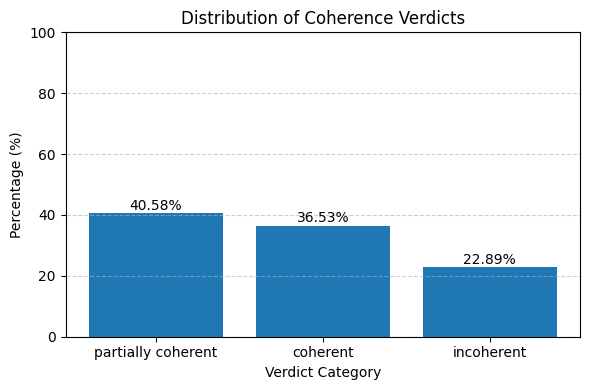

In [4]:
import matplotlib.pyplot as plt

verdict_percentages = (
    df["verdict"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .reset_index()
)

verdict_percentages.columns = ["Verdict", "Percentage"]

# Display table
print(verdict_percentages)

plt.figure(figsize=(6, 4))
plt.bar(
    verdict_percentages["Verdict"],
    verdict_percentages["Percentage"]
)

plt.ylabel("Percentage (%)")
plt.xlabel("Verdict Category")
plt.title("Distribution of Coherence Verdicts")
plt.ylim(0, 100)

for i, value in enumerate(verdict_percentages["Percentage"]):
    plt.text(i, value + 1, f"{value}%", ha="center", fontsize=10)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("verdict_distribution_bar.png", dpi=300)
plt.show()


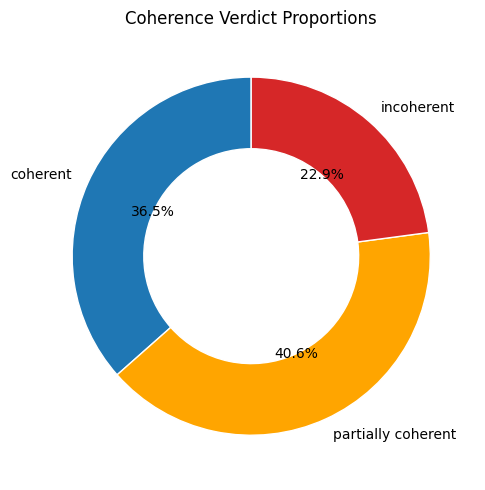

In [5]:
import matplotlib.pyplot as plt

# Ensure consistent ordering
order = ["coherent", "partially coherent", "incoherent"]

# Reorder dataframe safely
verdict_df = (
    verdict_percentages
    .set_index("Verdict")
    .reindex(order)
    .dropna()
)

# Define colors
color_map = {
    "coherent": "tab:blue",              # green
    "partially coherent": "orange",    # grey
    "incoherent": "#d62728"             # red
}

colors = [color_map[v] for v in verdict_df.index]

# Plot donut chart
plt.figure(figsize=(5, 5))
plt.pie(
    verdict_df["Percentage"],
    labels=verdict_df.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor="white")
)

plt.title("Coherence Verdict Proportions")
plt.tight_layout()
plt.savefig("verdict_distribution_donut_colored.png", dpi=300)
plt.show()
